In [1]:
from AFEP_parse import *
from alchemlyb.preprocessing import subsampling
import os
from scipy.signal import correlate
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.optimize import curve_fit, leastsq

# User parameters

In [2]:
path='/home/ezry/winHome/Documents/'
affix = '40windows_1000samples'
temperature = 303.15
decorrelate = False #Flag for automatic decorrelation
detectEQ = False #Flag for automatic equilibrium detection

In [3]:
#Define a function that takes, at most, three variables: step, simulated lambda, sampled lambda)
def Foo(t, l, nl):
    #return np.full(len(t), np.float64(l))
    return np.random.normal(size=len(t))


In [4]:
RT = 0.00198720650096 * temperature

In [5]:
def makeUNKFrame(windows=11, samples=10, timeFrequency=100, precision=3, first=0):
    #Make an empty data frame
    lambdas = np.round(np.linspace(0,1,windows), precision)
    dL = np.round(lambdas[1]-lambdas[0], precision)
    times = first+(timeFrequency*np.arange(samples)).astype(int) #steps are integers
    indcs = pd.MultiIndex.from_product([times, lambdas], names = ['time','fep-lambda']) #Fully cross the FEPs and the steps like you'd have in raw data (from NAMD at least)
    data = pd.DataFrame(columns=lambdas, index=indcs) #build the dataframe
    data.sort_index(level=1) #make it pretty
    
    return data, dL

In [6]:

def populateUNK(oldUNK, dL, func, precision=3):
    #Populate the data frame
    groups = oldUNK.groupby('fep-lambda')
    slices = []
    for thisL, group in groups:
        time = group.index.get_level_values(0)
        nextL = np.round(thisL+dL, precision)
        lastL = np.round(thisL-dL, precision)
        group[thisL] = np.full(len(time), np.float64(0.0))
        if thisL >= 0 and thisL < 1:
            group[nextL] = func(time, thisL, nextL)
        if thisL <= 1 and thisL > 0:
            group[lastL] = func(time, thisL, lastL)
            slices.append(group)
        slices.append(group)
    newUNK = pd.concat(slices).sort_index(axis=1).astype(np.float64)
    return newUNK

In [7]:
#Create an empty dataframe with of the appropriate size and with labels
#Arguments: nwindows, nsamples, timeFrequency (number of steps between samples), precision (number of decimal places to round lambdas), time value of the first sample
simUNK, dL = makeUNKFrame(windows=41, samples=1000, timeFrequency=100, precision=3, first=0)

In [8]:
simUNK = populateUNK(simUNK, dL, Foo)

In [9]:
bar = BAR()
bar.fit(simUNK)

l, l_mid, f, df, ddf, errors = get_BAR(bar)

changeAndError = f'\u0394G = {np.round(f.iloc[-1]*RT, 1)}\u00B1{np.round(errors[-1], 3)} kcal/mol'
print(changeAndError)

ΔG = -0.1±0.084 kcal/mol


# Plot the change in free energy based on MBAR estimates

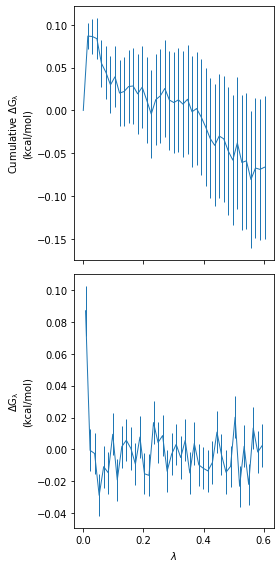

In [10]:
fig, (cumAx, eachAx) = plt.subplots(2,1, sharex=True)
# Cumulative change in kcal/mol
cumAx.errorbar(np.array(l)*RT, np.array(f)*RT, yerr=errors, marker=None, linewidth=1)
cumAx.set(ylabel=r'Cumulative $\rm\Delta G_{\lambda}$'+'\n(kcal/mol)')

# Per-window change in kcal/mol
plt.errorbar(np.array(l_mid)*RT, np.array(df)*RT, yerr=ddf, marker=None, linewidth=1)
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$\rm\Delta G_{\lambda}$'+'\n(kcal/mol)')

fig.set_figwidth(4)
fig.set_figheight(8)
fig.tight_layout()
plt.savefig(f'{path}dG_{affix}.pdf')
plt.savefig(f'{path}dG_{affix}.png', dpi=600)
plt.show()

# Plot the estimated total change in free energy as a function of simulation time; contiguous subsets starting at t=0 ("Forward") and t=end ("Reverse")

In [12]:
    
def altConvergence(u_nk, nbins):
    groups = u_nk.groupby('fep-lambda')

    #return data_list
    
    forward = []
    forward_error = []
    backward = []
    backward_error = []
    num_points = nbins
    for i in range(1, num_points+1):
        # forward
        partial = subSample(groups, 100*(i-1)/num_points, 100*i/num_points)
        estimate = BAR().fit(partial)
        l, l_mid, f, df, ddf, errors = get_BAR(estimate)
        
        forward.append(f.iloc[-1])
        forward_error.append(errors[-1])

    return np.array(forward), np.array(forward_error)

In [13]:
def doConvPlot(ax, X, fs, ferr, fwdColor, label=None):
    ax.errorbar(X, fs, yerr=ferr, marker=None, linewidth=1, color=fwdColor, markerfacecolor='white', markeredgewidth=1, markeredgecolor=fwdColor, ms=5, label=label)
    return ax

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w

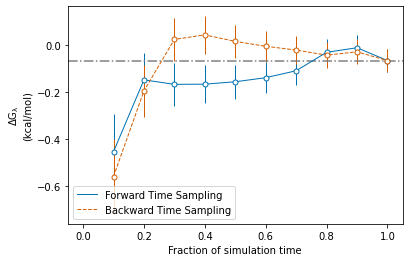

In [14]:
forward, fwdErr, backward, bwdErr = doConvergence(simUNK)
fig, ax = plt.subplots(1,1)
convergencePlot(ax, np.array(forward)*RT, np.array(fwdErr)*RT, np.array(backward)*RT, np.array(bwdErr)*RT)
ax.legend()
ax.set(ylabel=r'$\rm\Delta G_{\lambda}$'+'\n(kcal/mol)', xlabel='Fraction of simulation time')
plt.savefig(f'{path}_ES_Convergence_{affix}.pdf')
plt.savefig(f'{path}_ES_Convergence_{affix}.png', dpi=600)

In [15]:
groups = simUNK.groupby('fep-lambda')
trimmed = subSample(groups, 30, 100)

In [16]:
nbins=100
fs, Err = altConvergence(trimmed, nbins)

/home/ezry/anaconda3/envs/jupEnv/lib/python3.9/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ezry/anaconda3/envs/jupEnv/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/ezry/anaconda3/envs/jupEnv/lib/python3.9/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


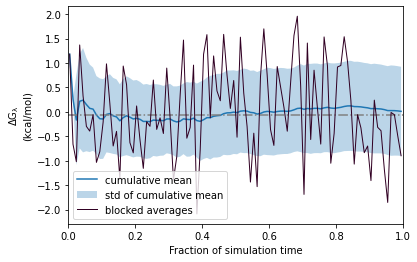

In [17]:
fig, ax = plt.subplots(1,1)
lspace = np.linspace(0,1,nbins+1)
X = (lspace[1:]+lspace[:-1])/2
#doConvPlot(ax, X, np.multiply(fs,RT), np.multiply(Err,RT), "#310023") 
doConvPlot(ax, X, np.multiply(fs,RT), None, "#310023", label="blocked averages") 

#ax.plot(X, moving_average(fs, 4)*RT, label='moving average')

cumMean = np.cumsum(fs)/np.arange(1,len(fs)+1)*RT
ax.plot(X, cumMean, label='cumulative mean')

cumStd = [RT*np.std(fs[:i]) for i in range(0,len(fs))]
ax.fill_between(X, cumMean+cumStd, cumMean-cumStd, alpha=0.3, label='std of cumulative mean')

ax.legend()

ax.xaxis.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])

finalMean = f.iloc[-1]*RT
ax.axhline(y= finalMean, linestyle='-.', color='gray')
#ax.plot(0, finalMean, linewidth=1, color=fwdColor)
ax.set(xlim=(0,1))
#ax.legend()
ax.set(ylabel=r'$\rm\Delta G_{\lambda}$'+'\n(kcal/mol)', xlabel='Fraction of simulation time')
#plt.savefig(f'{path}convergence_BlocksWAve_n{nbins}{affix}.pdf')
#plt.savefig(f'{path}convergence_BlocksWAve_n{nbins}{affix}.png', dpi=600)
plt.show()

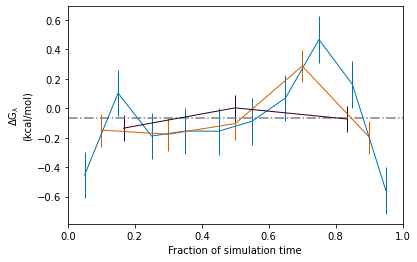

In [18]:
fwdColor='#0072B2'
bwdColor='#D55E00'
fig, ax = plt.subplots(1,1)

nbins = 10
fs, Err = altConvergence(simUNK, nbins)
lspace = np.linspace(0,1,nbins+1)
X = (lspace[1:]+lspace[:-1])/2
doConvPlot(ax, X, fs*RT, Err*RT, fwdColor)

nbins = 5
fs, Err = altConvergence(simUNK, nbins)
lspace = np.linspace(0,1,nbins+1)
X = (lspace[1:]+lspace[:-1])/2
doConvPlot(ax, X, fs*RT, Err*RT, bwdColor)

nbins=3
fs, Err = altConvergence(simUNK, nbins)
lspace = np.linspace(0,1,nbins+1)
X = (lspace[1:]+lspace[:-1])/2
doConvPlot(ax, X, fs*RT, Err*RT, "#310023")

ax.xaxis.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])

finalMean = f.iloc[-1]
ax.axhline(y= finalMean*RT, linestyle='-.', color='gray')
#ax.plot(0, finalMean, linewidth=1, color=fwdColor)
ax.set(xlim=(0,1))
#ax.legend()
ax.set(ylabel=r'$\rm\Delta G_{\lambda}$'+'\n(kcal/mol)', xlabel='Fraction of simulation time')
plt.savefig(f"{path}_multiScaleBlockAves_{affix}.pdf")
plt.savefig(f"{path}_multiScaleBlockAves_{affix}.png", dpi=600)
plt.show()

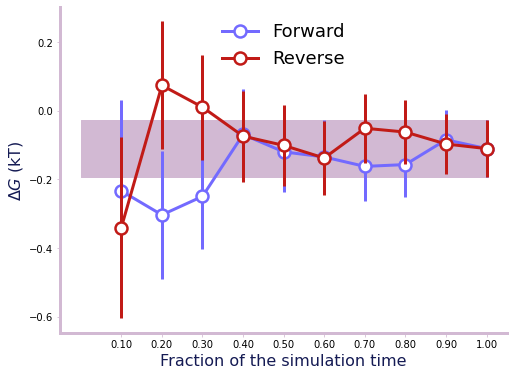

In [19]:
convergence_plot(simUNK, l)
plt.savefig(f"{path}_currentConvergence_{affix}.pdf")


# Use an exponential estimator to assess residual discrepancies and check for hysteresis

The PDF is estimated with Scipy's Gaussian Kernel with automatic bandwidth determination

In [20]:
l, l_mid, dG_f, dG_b = get_EXP(simUNK)

/home/ezry/anaconda3/envs/jupEnv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/ezry/anaconda3/envs/jupEnv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/ezry/anaconda3/envs/jupEnv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dty

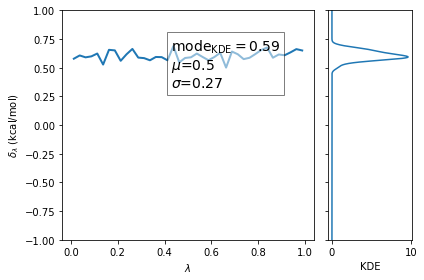

In [21]:
fig, (hystAx, pdfAx) = plt.subplots(1, 2, sharey=True, gridspec_kw={'width_ratios': [3, 1]})

diff = (dG_f + np.array(dG_b))*RT
hystAx.plot(l_mid, diff, linewidth=2)
hystAx.set(xlabel=r'$\lambda$', ylabel=r'$\delta_\lambda$ (kcal/mol)')
plt.ylim(-1,1)


pdfY, edges = np.histogram(diff, bins=20, density=True)
pdfX = (edges[1:] + edges[:-1])/2
#pdfAx.plot(pdfY, pdfX, label="histogrammed")


kernel = sp.stats.gaussian_kde(diff)
samples = np.linspace(-1, 1, 1000)
pdfAx.plot(kernel(samples), samples, label='KDE')

pdfAx.set(xlabel="KDE")
std = np.std(X)
mean = np.average(X)
mode = pd.Series(kernel(samples), index=samples).idxmax()
textstr = r"$\rm{mode_{KDE}=}$"+f"{np.round(mode,2)}"+"\n"+fr"$\mu$={np.round(mean,2)}"+"\n"+fr"$\sigma$={np.round(std,2)}"


props = dict(boxstyle='square', facecolor='white', alpha=0.5)
hystAx.text(0.35, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

fig.tight_layout()

plt.savefig(f"{path}discrepancies_{affix}.pdf")
plt.savefig(f"{path}discrepancies_{affix}.png", dpi=600)
plt.show()

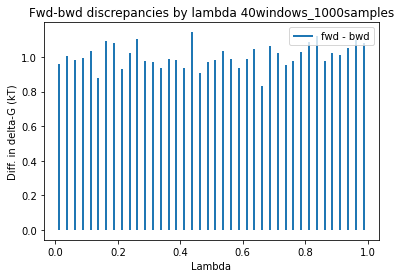

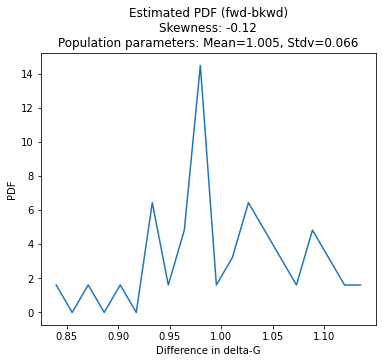

In [22]:
plt.vlines(l_mid, np.zeros(len(l_mid)), dG_f + np.array(dG_b), label="fwd - bwd", linewidth=2)

plt.legend()
plt.title(f'Fwd-bwd discrepancies by lambda {affix}')
plt.xlabel('Lambda')
plt.ylabel('Diff. in delta-G (kT)')
plt.savefig(f'{path}discrepancies_{affix}.png', dpi=600)

X, Y, pdfX, pdfY, fitted, pdfXnorm, pdfYnorm, pdfYexpected = getPDF(dG_f, dG_b)

#plot the data
fig, pdfAx = plt.subplots(1, 1)
plt.xlabel('Difference in delta-G')

pdfAx.plot(pdfX, pdfY,  label="Estimated Distribution")
pdfAx.set_ylabel("PDF")

fig.set_figheight(5)
pdfAx.title.set_text(f"Estimated PDF (fwd-bkwd)\nSkewness: {np.round(skew(X),2)}\nPopulation parameters: Mean={np.round(np.average(X),3)}, Stdv={np.round(np.std(X),3)}")
plt.savefig(f"{path}pdf_{affix}.png", dpi=600)


plt.show()